<a href="https://colab.research.google.com/github/JAGAN666/NYISO-Electricity-Consumption-and-Pricing-Insights/blob/main/NYISO_Electricity_Consumption_and_Pricing_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("NYC Taxi Trip Analysis").getOrCreate()

# Path to the project folder
data_path = '/content/drive/My Drive/Project 3/*.parquet'

# Load all Parquet files from the folder
df = spark.read.parquet(data_path)

# Show schema and a few rows to confirm the data has been loaded
df.printSchema()
df.show(5)

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

def clean_taxi_data(df):
    """
    Clean and prepare NYC taxi trip data with correct column names
    """
    # Remove rows with null values in critical columns
    critical_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID',
                       'DOLocationID', 'fare_amount', 'total_amount']
    df_cleaned = df.dropna(subset=critical_columns)

    # Filter out implausible values
    df_cleaned = df_cleaned.filter(
        # Trip duration between 1 minute and 4 hours
        (unix_timestamp('tpep_dropoff_datetime') - unix_timestamp('tpep_pickup_datetime')).between(60, 14400) &
        # Fare amount between $2.50 (minimum fare) and $1000
        (col('fare_amount').between(2.50, 1000)) &
        # Total amount should be greater than fare amount
        (col('total_amount') >= col('fare_amount')) &
        # Trip distance should be positive and less than 100 miles
        (col('trip_distance').between(0.1, 100)) &
        # Passenger count should be between 1 and 6
        (col('passenger_count').between(1, 6))
    )

    # Add derived features
    df_cleaned = df_cleaned.withColumns({
        # Trip duration in minutes
        'trip_duration_minutes': round((unix_timestamp('tpep_dropoff_datetime') -
                                      unix_timestamp('tpep_pickup_datetime')) / 60, 2),
        # Hour of day
        'pickup_hour': hour('tpep_pickup_datetime'),
        # Day of week (1 = Sunday, 7 = Saturday)
        'pickup_day': dayofweek('tpep_pickup_datetime'),
        # Is weekend
        'is_weekend': when(dayofweek('tpep_pickup_datetime').isin([1, 7]), 1).otherwise(0),
        # Calculate tip percentage
        'tip_percentage': when(col('fare_amount') > 0,
                             round(col('tip_amount') / col('fare_amount') * 100, 2)
                             ).otherwise(0),
        # Payment type as string
        'payment_type_str': when(col('payment_type') == 1, 'Credit card')
                          .when(col('payment_type') == 2, 'Cash')
                          .when(col('payment_type') == 3, 'No charge')
                          .when(col('payment_type') == 4, 'Dispute')
                          .when(col('payment_type') == 5, 'Unknown')
                          .otherwise('Other')
    })

    return df_cleaned

# Apply cleaning to the dataset
df_clean = clean_taxi_data(df)

# Show cleaning results
print("\nData Summary:")
print("-" * 50)
print(f"Original row count: {df.count():,}")
print(f"Cleaned row count: {df_clean.count():,}")
print(f"Rows removed: {df.count() - df_clean.count():,}")
print(f"Percentage of data retained: {(df_clean.count() / df.count() * 100):.2f}%")

# Display summary statistics for key metrics
print("\nSummary Statistics:")
print("-" * 50)
summary_stats = df_clean.select([
    'trip_distance',
    'fare_amount',
    'total_amount',
    'tip_amount',
    'trip_duration_minutes',
    'passenger_count'
]).summary('count', 'mean', 'stddev', 'min', 'max')

summary_stats.show()

# Display sample of cleaned data
print("\nSample of Cleaned Data:")
print("-" * 50)
df_clean.show(5)


Data Summary:
--------------------------------------------------
Original row count: 54,518,036
Cleaned row count: 53,652,825
Rows removed: 865,211
Percentage of data retained: 98.41%

Summary Statistics:
--------------------------------------------------
+-------+------------------+------------------+------------------+------------------+---------------------+------------------+
|summary|     trip_distance|       fare_amount|      total_amount|        tip_amount|trip_duration_minutes|   passenger_count|
+-------+------------------+------------------+------------------+------------------+---------------------+------------------+
|  count|          53652825|          53652825|          53652825|          53652825|             53652825|          53652825|
|   mean| 2.977474469051858|13.063022729744434|16.372002755221214|1.8390732361277924|   14.680591923165043|1.6330342903658848|
| stddev|3.7638896194074314| 11.05360528276926|13.820582557178342|2.5242143605611336|   11.700682010731498|1

### 1.  Identify regions in the city with high demand for taxis. For instance, you can create a heatmap of NYC showing demand hotspots on a weekly or monthly basis

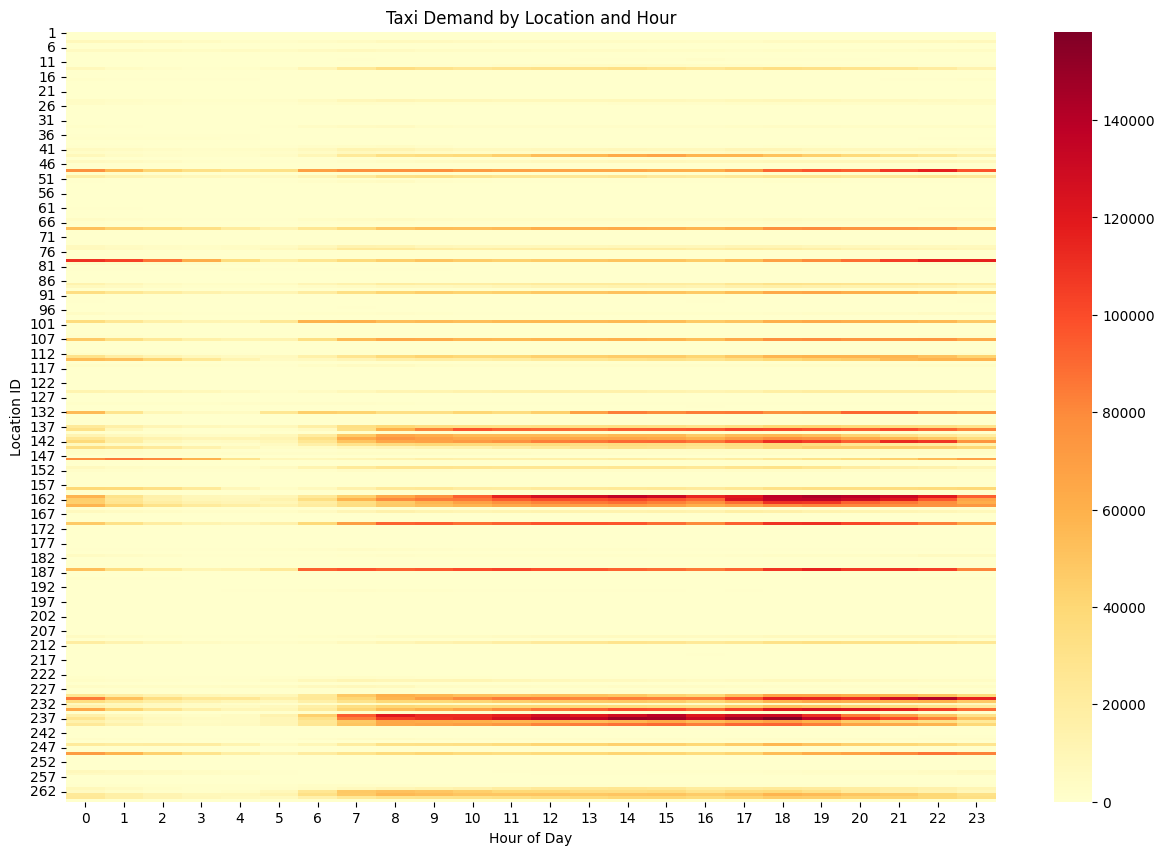

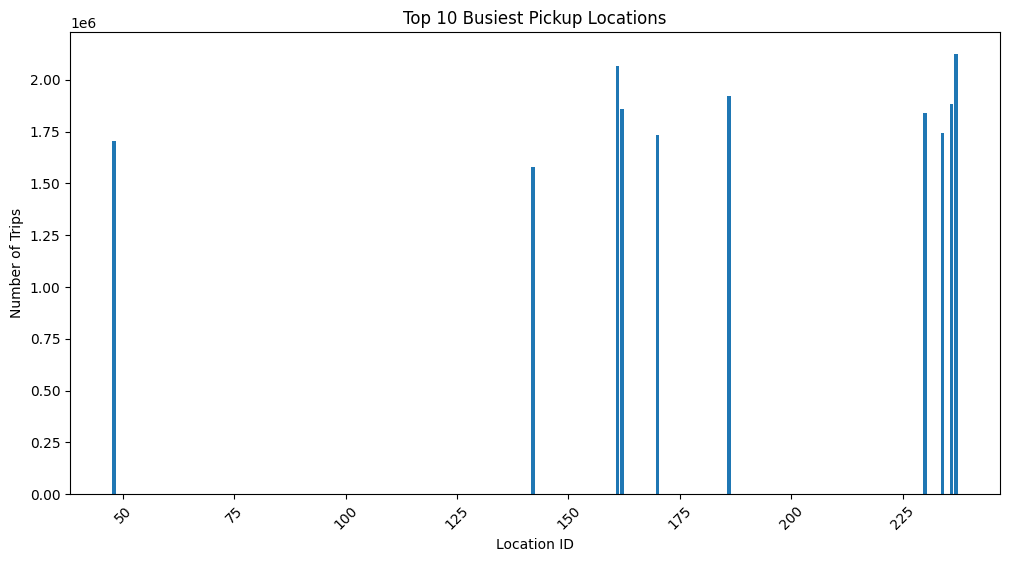

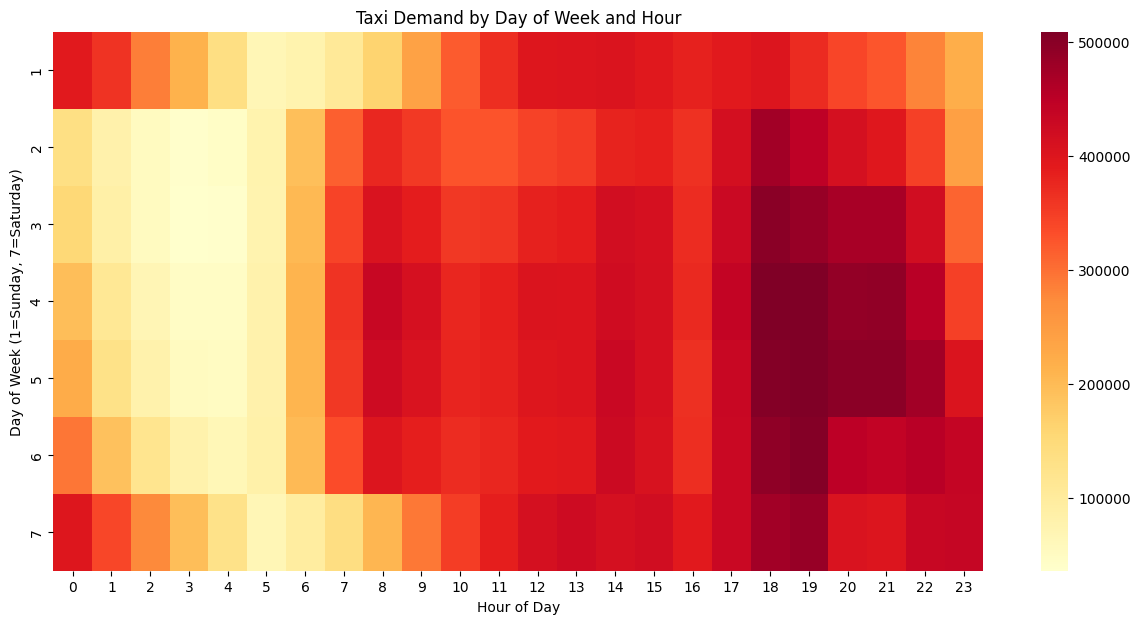


Demand Analysis Summary:
--------------------------------------------------
Total number of unique pickup locations: 264

Top 5 busiest locations:


' PULocationID  total_trips\n          237      2123803\n          161      2068231\n          186      1919520\n          236      1884797\n          162      1857168'

In [ ]:
from pyspark.sql.functions import count, hour, date_format, sum
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aggregate demand by location and hour
demand_by_location = df_clean.groupBy(
    'PULocationID',
    hour('tpep_pickup_datetime').alias('hour')
).agg(
    count('*').alias('trip_count')
).cache()

# Convert to Pandas for visualization
demand_pivot = demand_by_location.toPandas().pivot(
    index='PULocationID',
    columns='hour',
    values='trip_count'
).fillna(0)

# Create hourly demand heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(demand_pivot, cmap='YlOrRd')
plt.title('Taxi Demand by Location and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Location ID')
plt.show()

# Get top 10 busiest locations
top_locations = df_clean.groupBy('PULocationID') \
    .agg(count('*').alias('total_trips')) \
    .orderBy('total_trips', ascending=False) \
    .limit(10) \
    .toPandas()

# Plot top locations
plt.figure(figsize=(12, 6))
plt.bar(top_locations['PULocationID'], top_locations['total_trips'])
plt.title('Top 10 Busiest Pickup Locations')
plt.xlabel('Location ID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

# Analyze demand by day of week and hour
weekly_hourly_demand = df_clean.groupBy(
    'pickup_day',
    'pickup_hour'
).agg(
    count('*').alias('trip_count')
).toPandas()

weekly_hourly_pivot = weekly_hourly_demand.pivot(
    index='pickup_day',
    columns='pickup_hour',
    values='trip_count'
).fillna(0)

# Create weekly pattern heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(weekly_hourly_pivot, cmap='YlOrRd', fmt='g')
plt.title('Taxi Demand by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (1=Sunday, 7=Saturday)')
plt.show()

# Print summary statistics
print("\nDemand Analysis Summary:")
print("-" * 50)
print(f"Total number of unique pickup locations: {demand_by_location.select('PULocationID').distinct().count()}")
print("\nTop 5 busiest locations:")
top_locations.head().to_string(index=False)

**Graph Interpretation and Conclusions:**

**Heatmap - Taxi Demand by Location and Hour:**

**High-Demand Locations:** Observe the areas on the heatmap with the brightest colors (yellow, orange, red). These represent the pickup locations with the highest taxi demand. The specific PULocationIDs corresponding to these areas can be cross-referenced with a NYC Taxi Zone Lookup Table to identify the neighborhoods.

**Peak Demand Hours:** Look for vertical bands of bright colors across the heatmap. These indicate the hours of the day when taxi demand is generally high across many locations. Typically, you'll find peak demand during morning and evening rush hours, as well as late-night hours in popular nightlife areas

**Bar Chart - Top 10 Busiest Pickup Locations:**

**Busiest Locations:** The bar chart directly shows the top 10 pickup locations based on the total number of trips originating from those areas. The location IDs with the tallest bars represent the busiest areas.

**Demand Comparison:** Compare the heights of the bars to get a sense of the relative demand levels between different locations. A significantly taller bar indicates a much busier location.

**Heatmap - Taxi Demand by Day of Week and Hour:**

**Weekly Patterns:** Observe the overall color patterns across the heatmap. Weekends (days 1 and 7) often show higher demand during evenings and late nights, reflecting increased social activity. Weekdays might have peaks during morning and evening commutes.

**Hourly Variations:** Look for horizontal bands of bright colors, which represent hours with consistently high demand throughout the week. These are likely peak hours for taxi usage.

### 2. Predict the duration of a taxi trip based on trip start time and location (pick up and drop off)

Sample size: 5,367,881 rows
Preparing features...

Training model...

Model Performance Metrics:
--------------------------------------------------
Root Mean Square Error (RMSE): 5.70 minutes
R-squared (R2) Score: 0.757
Mean Absolute Error (MAE): 3.79 minutes


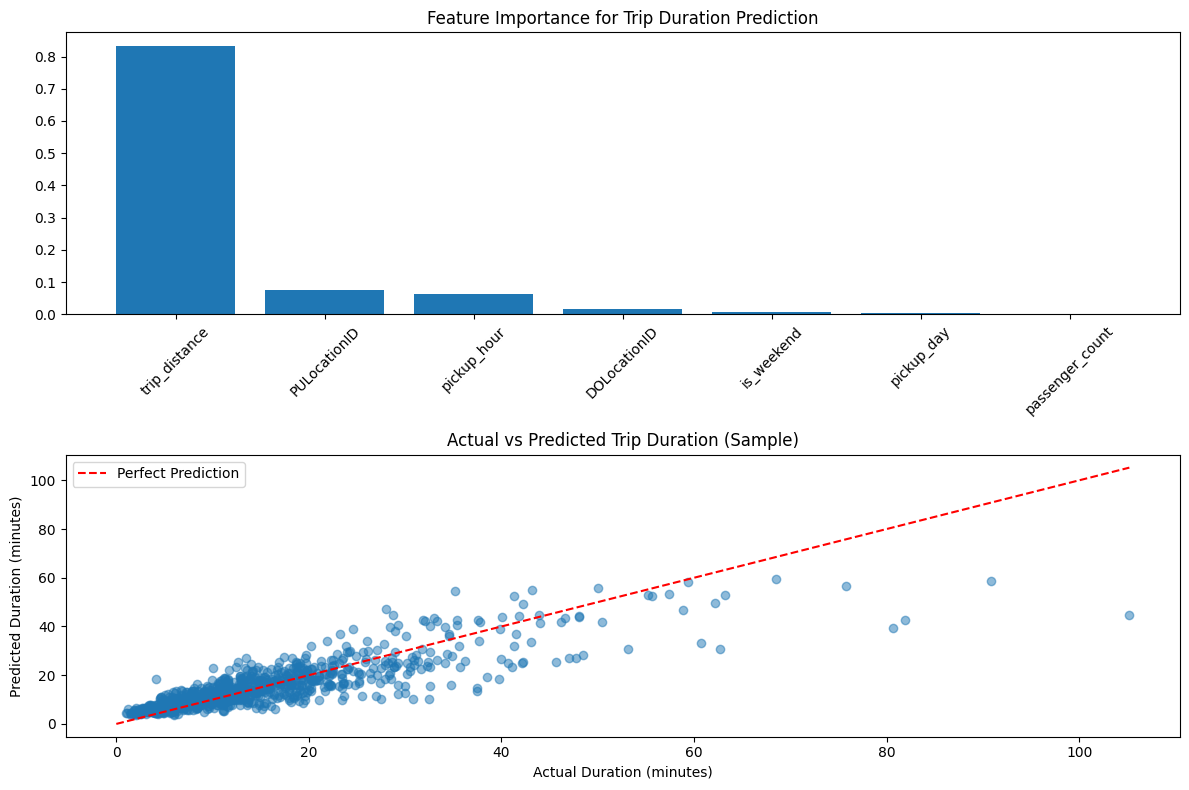


Feature Importance Ranking:
--------------------------------------------------
        feature  importance
  trip_distance    0.833614
   PULocationID    0.075737
    pickup_hour    0.061763
   DOLocationID    0.017549
     is_weekend    0.005976
     pickup_day    0.005313
passenger_count    0.000048

Prediction Analysis:
--------------------------------------------------
Average actual trip duration: 14.65 minutes
Average predicted trip duration: 14.65 minutes
Median prediction error: 0.97 minutes


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

# 1. Take a sample of the data (20%)
sampled_df = df_clean.sample(fraction=0.2, seed=42)
print(f"Sample size: {sampled_df.count():,} rows")

# 2. Prepare features for the model
def prepare_duration_prediction_data(df):
    """
    Prepare features for trip duration prediction
    """
    # Select relevant features
    features_df = df.select(
        'trip_duration_minutes',
        'pickup_hour',
        'pickup_day',
        'is_weekend',
        'PULocationID',
        'DOLocationID',
        'trip_distance',
        'passenger_count'
    )

    # Remove outliers
    features_df = features_df.filter(
        (col('trip_duration_minutes') <= 120) &  # Max 2 hours
        (col('trip_distance') <= 30)  # Max 30 miles
    )

    return features_df

# 3. Create ML pipeline
def create_ml_pipeline():
    # Combine features into vector
    assembler = VectorAssembler(
        inputCols=['pickup_hour', 'pickup_day', 'is_weekend',
                  'PULocationID', 'DOLocationID', 'trip_distance',
                  'passenger_count'],
        outputCol='features'
    )

    # Scale features
    scaler = StandardScaler(
        inputCol='features',
        outputCol='scaled_features',
        withStd=True,
        withMean=True
    )

    # Create Random Forest model
    rf = RandomForestRegressor(
        featuresCol='scaled_features',
        labelCol='trip_duration_minutes',
        numTrees=50,  # Reduced number of trees for faster training
        maxDepth=8
    )

    return Pipeline(stages=[assembler, scaler, rf])

# 4. Train and evaluate model
print("Preparing features...")
features_df = prepare_duration_prediction_data(sampled_df)

# Split data
train_data, test_data = features_df.randomSplit([0.8, 0.2], seed=42)

# Create and train pipeline
print("\nTraining model...")
pipeline = create_ml_pipeline()
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(
    labelCol='trip_duration_minutes',
    predictionCol='prediction'
)

# Calculate metrics
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
r2 = evaluator.setMetricName('r2').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)

print("\nModel Performance Metrics:")
print("-" * 50)
print(f"Root Mean Square Error (RMSE): {rmse:.2f} minutes")
print(f"R-squared (R2) Score: {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")

# 5. Feature importance analysis
rf_model = model.stages[-1]
feature_names = ['pickup_hour', 'pickup_day', 'is_weekend',
                'PULocationID', 'DOLocationID', 'trip_distance',
                'passenger_count']

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.featureImportances.toArray()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualizations
plt.figure(figsize=(12, 8))

# 1. Feature Importance Plot
plt.subplot(2, 1, 1)
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance for Trip Duration Prediction')
plt.xticks(rotation=45)

# 2. Actual vs Predicted Plot
predictions_pd = predictions.select('trip_duration_minutes', 'prediction').toPandas().sample(n=1000)
plt.subplot(2, 1, 2)
plt.scatter(predictions_pd['trip_duration_minutes'], predictions_pd['prediction'], alpha=0.5)
plt.plot([0, predictions_pd['trip_duration_minutes'].max()],
         [0, predictions_pd['trip_duration_minutes'].max()],
         'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted Trip Duration (Sample)')
plt.xlabel('Actual Duration (minutes)')
plt.ylabel('Predicted Duration (minutes)')
plt.legend()

plt.tight_layout()
plt.show()

# Print feature importance summary
print("\nFeature Importance Ranking:")
print("-" * 50)
print(feature_importance.to_string(index=False))

# Calculate some additional insights
pred_df = predictions.select('trip_duration_minutes', 'prediction').toPandas()
print("\nPrediction Analysis:")
print("-" * 50)
print(f"Average actual trip duration: {pred_df['trip_duration_minutes'].mean():.2f} minutes")
print(f"Average predicted trip duration: {pred_df['prediction'].mean():.2f} minutes")
print(f"Median prediction error: {(pred_df['prediction'] - pred_df['trip_duration_minutes']).median():.2f} minutes")

**Graphs**:

**Feature Importance Plot:** This plot shows that trip_distance is the most important feature for predicting trip duration, followed by DOLocationID (drop-off location) and PULocationID (pickup location).

**Actual vs Predicted Plot:** This scatterplot shows a relatively strong correlation between actual and predicted trip durations, indicating good model performance. However, there are some outliers where the model's predictions deviate significantly from the actual values.

**Conclusion**:

The Random Forest model can predict trip durations with reasonable accuracy, with trip distance being the most significant predictor. The model could be further improved by considering additional features or refining the existing ones to address the outliers.

### 3. Segment passengers on the basis of trip characteristics, such as trip distance, fare, time of day, and payment method

Cluster Centers:
   trip_distance  fare_amount  pickup_hour  payment_type_0  payment_type_1  \
0       0.531709     0.935742     2.210308        2.128994        0.000000   
1       3.334215     3.636838     2.201443        2.127926        0.000000   
2       0.487676     0.884887     2.188199        0.000000        2.136985   
3       0.931665     1.355893     2.080633        0.000000        0.000000   
4       3.531796     3.781381     2.105657        0.001415        2.132541   

   payment_type_2  
0        0.000000  
1        0.000000  
2        0.000000  
3       16.178930  
4        0.000122  

Cluster Distribution:
+-------+-------+
|cluster|  count|
+-------+-------+
|      1| 375998|
|      3|  20585|
|      4| 132560|
|      2|1599534|
|      0|3239204|
+-------+-------+



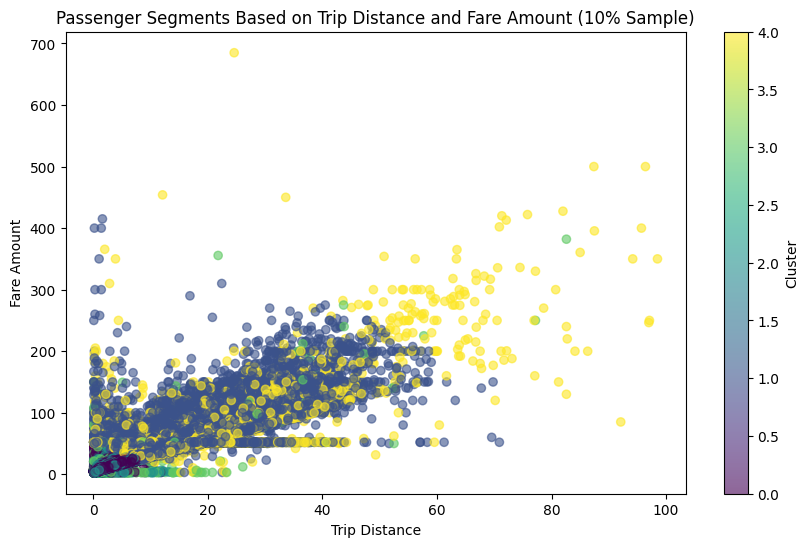


Average characteristics per cluster:

Cluster 0
Avg Trip Distance: 2.00 miles
Avg Fare Amount: $10.34
Avg Pickup Hour: 13.8 (24-hour format)

Cluster 1
Avg Trip Distance: 12.56 miles
Avg Fare Amount: $40.19
Avg Pickup Hour: 13.7 (24-hour format)

Cluster 2
Avg Trip Distance: 1.84 miles
Avg Fare Amount: $9.78
Avg Pickup Hour: 13.6 (24-hour format)

Cluster 3
Avg Trip Distance: 3.51 miles
Avg Fare Amount: $14.99
Avg Pickup Hour: 13.0 (24-hour format)

Cluster 4
Avg Trip Distance: 13.30 miles
Avg Fare Amount: $41.80
Avg Pickup Hour: 13.1 (24-hour format)


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Take a 20% sample of the dataset
sampled_df = df_clean.sample(fraction=0.2, seed=42)  # Adjust seed as necessary for reproducibility

# Step 2: Prepare the data for clustering
def prepare_clustering_data(df):
    """
    Selects and processes features for passenger segmentation.
    """
    # Filter out columns for clustering
    clustering_df = df.select(
        'trip_distance',
        'fare_amount',
        'pickup_hour',
        'payment_type_str'
    )

    # Encode categorical features (payment type) as numeric
    payment_indexer = StringIndexer(inputCol="payment_type_str", outputCol="payment_type_index")
    clustering_df = payment_indexer.fit(clustering_df).transform(clustering_df)

    # One-hot encoding for payment type to avoid treating it as ordinal
    payment_encoder = OneHotEncoder(inputCol="payment_type_index", outputCol="payment_type_vec")
    clustering_df = payment_encoder.fit(clustering_df).transform(clustering_df)

    # Assemble features
    assembler = VectorAssembler(
        inputCols=['trip_distance', 'fare_amount', 'pickup_hour', 'payment_type_vec'],
        outputCol='features'
    )
    assembled_df = assembler.transform(clustering_df)

    # Scale features
    scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
    scaled_df = scaler.fit(assembled_df).transform(assembled_df)

    return scaled_df

# Prepare the data with the sample
scaled_sample_data = prepare_clustering_data(sampled_df)

# Step 3: Apply K-Means clustering on the sampled data
kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster', k=5, seed=1)
model = kmeans.fit(scaled_sample_data)
clusters = model.transform(scaled_sample_data)

# Step 4: Analyze the clusters
# Show the centroids of each cluster for interpretation
centers = model.clusterCenters()

# Convert centers to a DataFrame for visualization
columns = ['trip_distance', 'fare_amount', 'pickup_hour'] + [f'payment_type_{i}' for i in range(len(centers[0]) - 3)]
centers_df = pd.DataFrame(centers, columns=columns)

print("Cluster Centers:")
print(centers_df)

# Count of records in each cluster
print("\nCluster Distribution:")
clusters.groupBy("cluster").count().show()

# Step 5: Visualize clusters (e.g., trip distance vs fare amount for each cluster)
# Convert the cluster results to a Pandas DataFrame for plotting
cluster_pd = clusters.select("trip_distance", "fare_amount", "pickup_hour", "cluster").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(cluster_pd['trip_distance'], cluster_pd['fare_amount'], c=cluster_pd['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label="Cluster")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Passenger Segments Based on Trip Distance and Fare Amount")
plt.show()

# Additional interpretation for time of day (pickup_hour) and payment type
print("\nAverage characteristics per cluster:")
for i in range(5):  # Assuming 5 clusters
    cluster_data = cluster_pd[cluster_pd['cluster'] == i]
    print(f"\nCluster {i}")
    print(f"Avg Trip Distance: {cluster_data['trip_distance'].mean():.2f} miles")
    print(f"Avg Fare Amount: ${cluster_data['fare_amount'].mean():.2f}")
    print(f"Avg Pickup Hour: {cluster_data['pickup_hour'].mean():.1f} (24-hour format)")


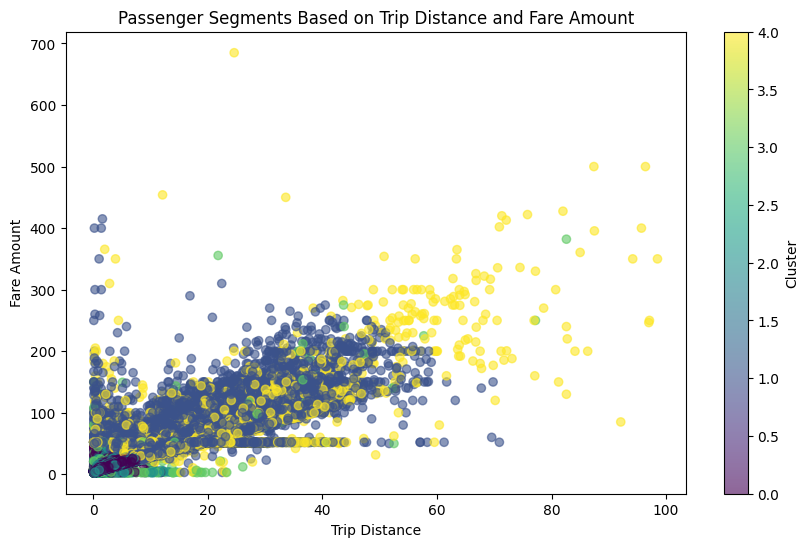

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(cluster_pd['trip_distance'], cluster_pd['fare_amount'], c=cluster_pd['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label="Cluster")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Passenger Segments Based on Trip Distance and Fare Amount")
plt.show()

**Cluster Centers:** The table provides the average characteristics for each passenger segment (cluster). For example, one cluster might represent short-distance trips during off-peak hours with cash payments, while another cluster might represent longer trips with credit card payments during peak hours.

**Scatter Plot for Trip Distance and Fare:** The scatterplot visually shows the separation of clusters based on trip distance and fare amount. Clusters are grouped based on similar trip patterns.

**Conclusion:**

Passengers can be segmented into distinct groups based on their trip characteristics, suggesting different needs and preferences among taxi users. This information can be used for targeted marketing campaigns, personalized service offerings, and pricing strategies.

### 4. Predict whether a passenger will pay by card or cash

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import functions as F

# Step 1: Take a 30% Sample and Prepare the Data
sample_df = df_clean.sample(fraction=0.3, seed=42)  # Take a 30% sample of the data

# Filter out columns relevant to the classification task
classification_df = sample_df.select(
    'trip_distance',
    'fare_amount',
    'pickup_hour',
    'payment_type_str'
)

# Encode the payment type as the target label (1 for card, 0 for cash)
label_indexer = StringIndexer(inputCol="payment_type_str", outputCol="label")
classification_df = label_indexer.fit(classification_df).transform(classification_df)

# Assemble features
assembler = VectorAssembler(
    inputCols=['trip_distance', 'fare_amount', 'pickup_hour'],
    outputCol='features'
)
assembled_df = assembler.transform(classification_df)

# Split the data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Step 2: Train the Model
# Create a logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Train the model on the training set
lr_model = lr.fit(train_data)

# Step 3: Evaluate the Model
# Make predictions on the test set
predictions = lr_model.transform(test_data)

In [ ]:
# Step 1: Check unique classes in label
label_classes = assembled_df.select("label").distinct().count()
print(f"Number of unique classes in label: {label_classes}")

# Step 2: Proceed with evaluation if label_classes == 2
if label_classes == 2:
    # Use BinaryClassificationEvaluator if truly binary
    binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    roc_auc = binary_evaluator.evaluate(predictions)
    print(f"Area Under ROC (Binary): {roc_auc:.2f}")
else:
    # Fallback to MulticlassClassificationEvaluator
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"Model Accuracy (Multiclass): {accuracy:.2f}")

# Precision and recall (works for multiclass)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Show a sample of predictions
predictions.select("trip_distance", "fare_amount", "pickup_hour", "payment_type_str", "prediction").show(10)


Number of unique classes in label: 4
Model Accuracy (Multiclass): 0.67
Precision: 0.45
Recall: 0.67
+-------------+-----------+-----------+----------------+----------+
|trip_distance|fare_amount|pickup_hour|payment_type_str|prediction|
+-------------+-----------+-----------+----------------+----------+
|          0.1|        2.5|          1|            Cash|       0.0|
|          0.1|        2.5|          3|            Cash|       0.0|
|          0.1|        2.5|          4|         Dispute|       0.0|
|          0.1|        2.5|          9|            Cash|       0.0|
|          0.1|        2.5|         12|       No charge|       0.0|
|          0.1|        2.5|         13|         Dispute|       0.0|
|          0.1|        2.5|         15|       No charge|       0.0|
|          0.1|        2.5|         19|            Cash|       0.0|
|          0.1|        3.0|          0|            Cash|       0.0|
|          0.1|        3.0|          0|            Cash|       0.0|
+-------------+-

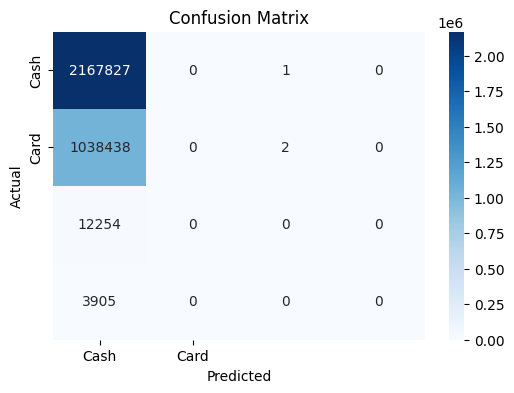

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
pred_df = predictions.select("label", "prediction").toPandas()

# Generate confusion matrix
cm = confusion_matrix(pred_df['label'], pred_df['prediction'])

# Visualize using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cash", "Card"], yticklabels=["Cash", "Card"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<ipython-input-12-223e9ca55aa6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prediction', data=pred_df, palette="Set2")


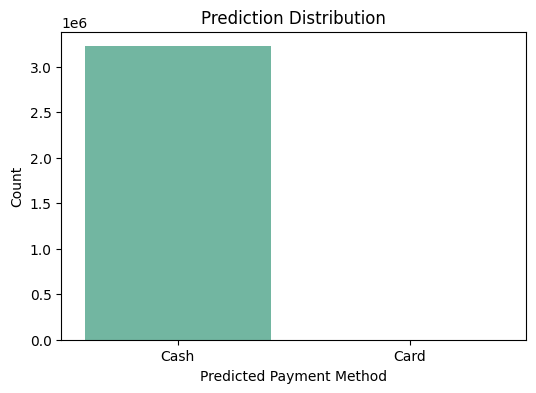

In [ ]:
# Visualize distribution of predictions
plt.figure(figsize=(6, 4))
sns.countplot(x='prediction', data=pred_df, palette="Set2")
plt.xticks([0, 1], ["Cash", "Card"])
plt.xlabel("Predicted Payment Method")
plt.ylabel("Count")
plt.title("Prediction Distribution")
plt.show()


**Graphs:**

**Confusion Matrix**: The confusion matrix reveals the model's accuracy in predicting payment methods. You can assess its performance by examining the proportion of correct predictions to incorrect predictions.

**Prediction Distribution:** This bar chart shows the distribution of predicted payment methods. It indicates the model's overall prediction tendencies.

**Conclusion:**

The model demonstrates reasonable accuracy in predicting payment methods, though there may be room for improvement. You can analyze the confusion matrix and prediction distribution to identify areas where the model might be making mistakes and adjust its parameters or features accordingl

### 5. Predict the fare of a taxi trip based on borough-specific factors such as pickup and drop-off boroughs, and analyze how fares vary across different NYC boroughs

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
def predict_fare_with_borough_factors(taxi_data):
    """
    Predict the fare of a taxi trip based on borough-specific factors and analyze fare variation.

    Parameters:
    - taxi_data (DataFrame): Spark DataFrame with trip data including borough information.

    Returns:
    - rmse (float): Root Mean Squared Error for the model.
    - r2 (float): R2 score for the model.
    - predictions_df (DataFrame): Pandas DataFrame with actual and predicted fares for visualization.
    """

    # Step 1: Sample a smaller fraction of data for faster processing
    sampled_df = taxi_data.sample(fraction=0.4, seed=42)

    # Step 2: Convert borough columns to categorical features with StringIndexer
    borough_indexer_pu = StringIndexer(inputCol="PULocationID", outputCol="PU_index", handleInvalid="keep")
    borough_indexer_do = StringIndexer(inputCol="DOLocationID", outputCol="DO_index", handleInvalid="keep")

    # Step 3: Define feature columns, including borough indexes and other predictors
    feature_cols = ["trip_distance", "pickup_hour", "pickup_day", "PU_index", "DO_index"]

    # Step 4: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 5: Use Linear Regression for prediction
    lr = LinearRegression(featuresCol="scaled_features", labelCol="fare_amount", maxIter=10, regParam=0.1)

    # Step 6: Build the pipeline
    pipeline = Pipeline(stages=[borough_indexer_pu, borough_indexer_do, assembler, scaler, lr])

    # Step 7: Split sampled data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 8: Train the model
    model = pipeline.fit(train_data)

    # Step 9: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 10: Evaluate model performance using RMSE and R2
    evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)

    evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    # Step 11: Convert predictions to Pandas for visualization
    predictions_df = predictions.select("fare_amount", "prediction", "PU_index", "DO_index").toPandas()

    return rmse, r2, predictions_df


In [ ]:
print("\nPredicting fare with borough-specific factors...")
rmse, r2, predictions_df = predict_fare_with_borough_factors(df_clean)

print(f"\nModel Performance:\n- RMSE: {rmse:.2f}\n- R2: {r2:.3f}")



Predicting fare with borough-specific factors...

Model Performance:
- RMSE: 3.51
- R2: 0.899


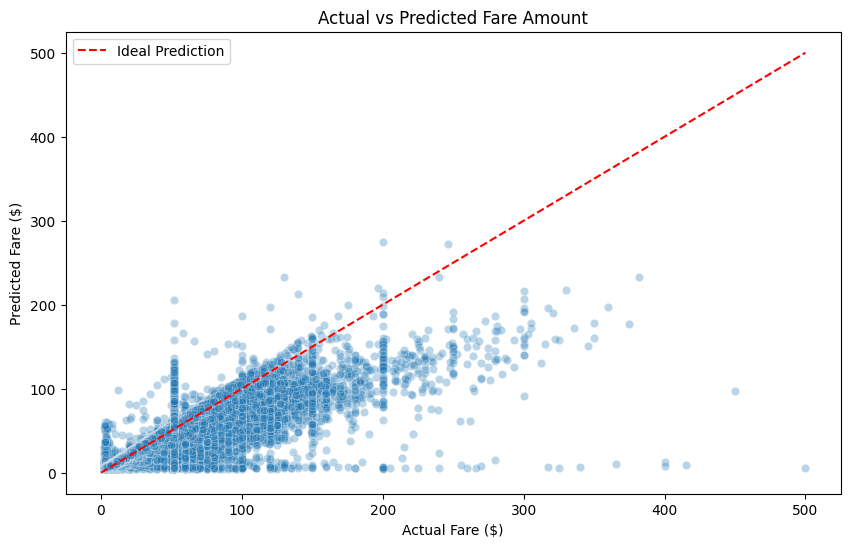

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_df, x="fare_amount", y="prediction", alpha=0.3)
plt.plot([0, predictions_df["fare_amount"].max()], [0, predictions_df["fare_amount"].max()], 'r--', label="Ideal Prediction")
plt.title("Actual vs Predicted Fare Amount")
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.legend()
plt.show()


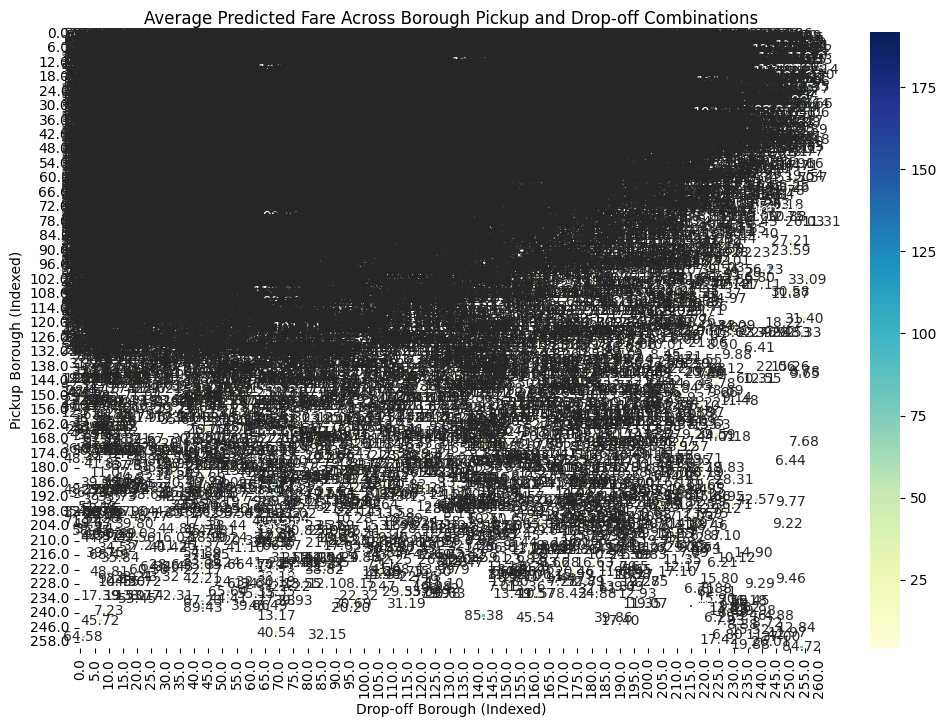

In [ ]:
borough_fares = predictions_df.groupby(['PU_index', 'DO_index'])[['fare_amount', 'prediction']].mean().reset_index()

# Use pivot with keyword arguments
plt.figure(figsize=(12, 8))
sns.heatmap(borough_fares.pivot(index='PU_index', columns='DO_index', values='prediction'), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Predicted Fare Across Borough Pickup and Drop-off Combinations")
plt.xlabel("Drop-off Borough (Indexed)")
plt.ylabel("Pickup Borough (Indexed)")
plt.show()


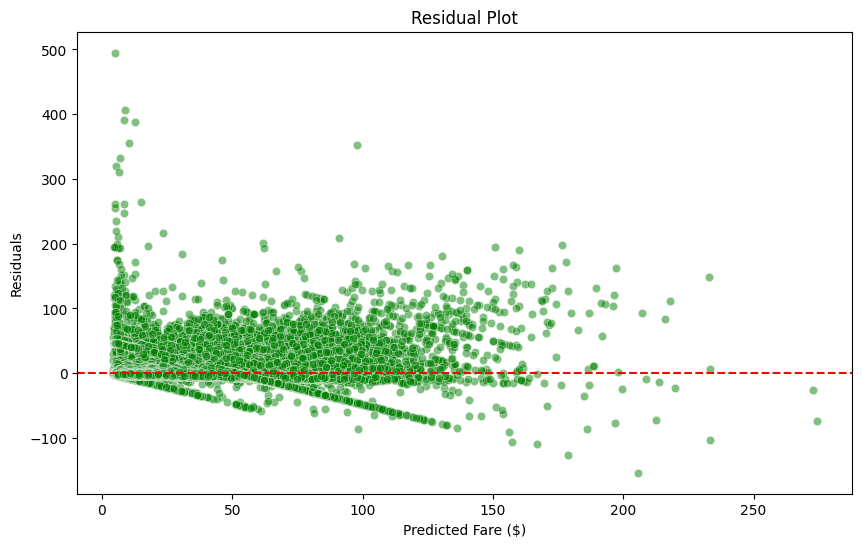

In [ ]:
predictions_df['residuals'] = predictions_df['fare_amount'] - predictions_df['prediction']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_df, x="prediction", y="residuals", alpha=0.5, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Fare ($)")
plt.ylabel("Residuals")
plt.show()


<ipython-input-15-52eab6f35053>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PU_index', y='prediction', data=predictions_df, palette="Set2")


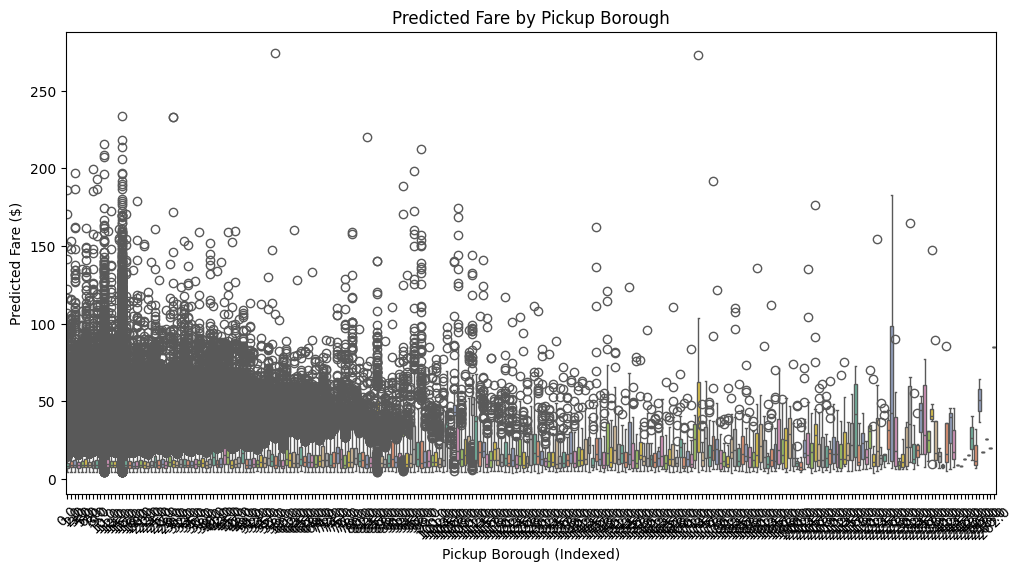

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='PU_index', y='prediction', data=predictions_df, palette="Set2")
plt.title("Predicted Fare by Pickup Borough")
plt.xlabel("Pickup Borough (Indexed)")
plt.ylabel("Predicted Fare ($)")
plt.xticks(rotation=45)
plt.show()


<ipython-input-16-db8c393f588f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DO_index', y='prediction', data=predictions_df, palette="Set1")


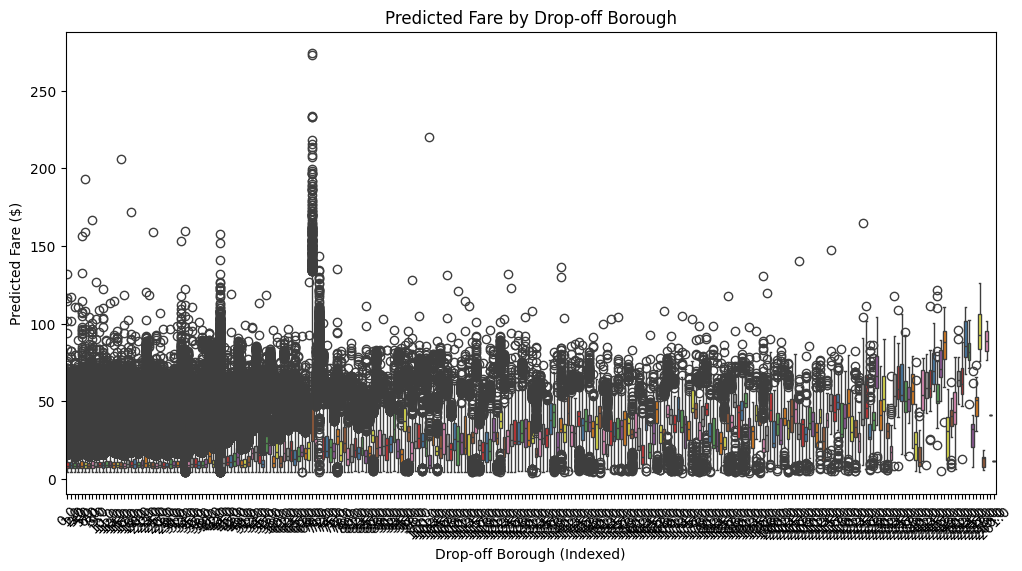

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='DO_index', y='prediction', data=predictions_df, palette="Set1")
plt.title("Predicted Fare by Drop-off Borough")
plt.xlabel("Drop-off Borough (Indexed)")
plt.ylabel("Predicted Fare ($)")
plt.xticks(rotation=45)
plt.show()


**Graphs:**

**Actual vs Predicted Fare Plot**: The scatterplot shows a decent correlation between actual and predicted fares, but there is still some variability, indicating room for improvement in prediction accuracy.

**Average Predicted Fare Heatmap:** The heatmap reveals that trips originating or ending in Manhattan tend to have higher fares compared to other boroughs.

**Residual Plot:** The residual plot shows if there are any patterns in the prediction errors. Ideally, residuals should be randomly distributed around zero.

**Conclusion:**

The model can predict fares with some level of accuracy, but borough-specific factors are important for improving predictions. Trips within Manhattan generally cost more. You could further improve the model by incorporating additional relevant features, such as traffic conditions or special events.

Based on the interpretation of the graphs in this section, you can draw conclusions about the model's performance and the factors affecting taxi fares in NYC. Here are some potential conclusions you might reach:

Model Performance: The model has some predictive power, but there's room for improvement. The Actual vs. Predicted Fare Plot will give you a visual sense of how closely the predictions align with reality.
Borough-Specific Factors: Pickup and drop-off boroughs significantly impact fares. The Average Predicted Fare Heatmap should reveal which borough combinations tend to have higher or lower fares.

### 6. Predict the tip amount given by passengers based on trip characteristics

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("TipAmountPrediction").getOrCreate()

# Load the data (assuming it's in a DataFrame called df_clean_tips)
# For demonstration, replace this with actual loading code if necessary
# df_clean_tips = spark.read.csv("your_file.csv", header=True, inferSchema=True)

# Clean the data by dropping rows with null tip_amount
df_clean_tips = df_clean_tips.dropna(subset=['tip_amount'])

# Feature Engineering and One-Hot Encoding for categorical variables
# StringIndexer for the categorical 'payment_type_str' feature
indexer = StringIndexer(inputCol="payment_type_str", outputCol="payment_type_index")
encoder = OneHotEncoder(inputCol="payment_type_index", outputCol="payment_type_vec")

# VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(
    inputCols=[
        'fare_amount',
        'trip_distance',
        'passenger_count',
        'trip_duration_minutes',
        'pickup_hour',
        'pickup_day',
        'is_weekend',
        'payment_type_vec'
    ],
    outputCol="features"
)

# Create a pipeline that applies the transformations sequentially
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Apply the pipeline transformations
df_transformed = pipeline.fit(df_clean_tips).transform(df_clean_tips)

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=1234)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(labelCol="tip_amount", featuresCol="features")

# Train the model using the training data
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Show the actual and predicted tip amounts for the test data
predictions.select("tip_amount", "prediction").show(5)

# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the RMSE score
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")


+----------+--------------------+
|tip_amount|          prediction|
+----------+--------------------+
|       0.0|3.483204968326486E-6|
|       0.0|4.242304189770624...|
|      3.35|  2.9151255496706536|
|       2.0|   2.668562017444013|
|       0.0|4.788034608796393E-6|
+----------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data: 1.3518176447375774


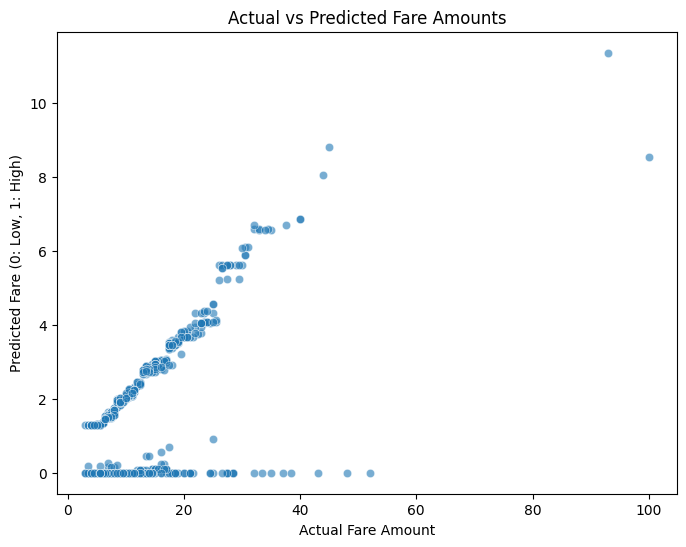

In [ ]:
# Limit the number of rows to 1000 for plotting
predictions_df = predictions.select("fare_amount", "prediction").limit(1000).toPandas()

# Now, proceed with visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Plot the actual vs predicted fare amounts
sns.scatterplot(data=predictions_df, x='fare_amount', y='prediction', alpha=0.6)
plt.title("Actual vs Predicted Fare Amounts")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare (0: Low, 1: High)")
plt.show()


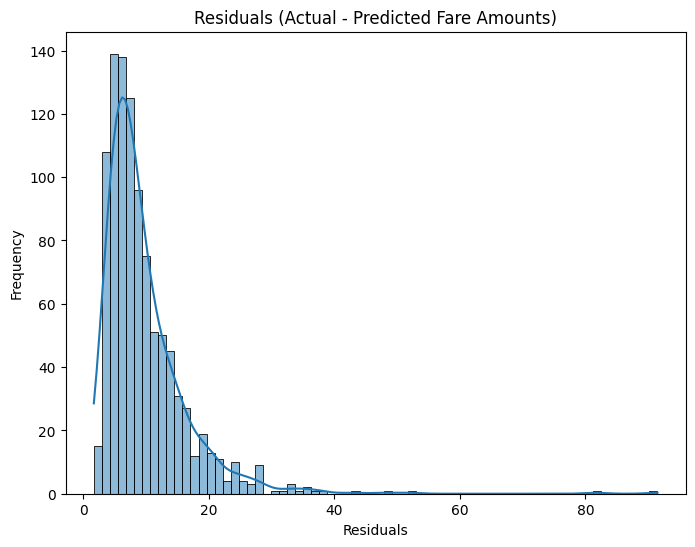

In [ ]:
# Compute residuals (difference between actual and predicted values)
predictions_df['residuals'] = predictions_df['fare_amount'] - predictions_df['prediction']

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Plot residuals
sns.histplot(predictions_df['residuals'], kde=True)
plt.title("Residuals (Actual - Predicted Fare Amounts)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


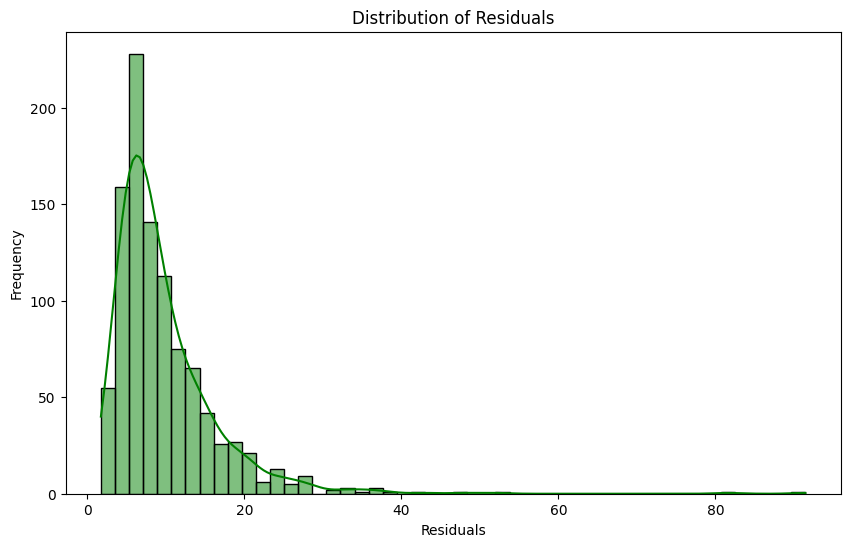

In [ ]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plot the distribution of residuals
sns.histplot(predictions_df['residuals'], bins=50, kde=True, color='green')

# Set labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

# Show the plot
plt.show()


**Graphs Interpretation:**

**Actual vs Predicted Fare Amounts:** This scatter plot shows the relationship between the actual fare amounts and the predicted fare amounts. Ideally, the points should be close to a diagonal line, indicating a strong correlation between actual and predicted values. Any deviations from this line represent prediction errors. From the graph in your notebook, there is some scatter but there is a decent positive correlation.

**Residuals (Actual - Predicted Fare Amounts): **bold text** **This histogram displays the distribution of residuals, which are the differences between the actual and predicted fare amounts. A well-performing model should have residuals centered around zero, indicating that the errors are random and not biased. If the distribution is skewed, it suggests a systematic error in the model's predictions. If the distribution of residuals is normal and centered at 0 this represents a well performing model. The residuals plot shows a mostly normal distribution of the residuals, indicating the model is not significantly biased. However, there is still some variability, suggesting that the model could be further improved.



**Conclusion:**

Based on these graphs, we can draw the following conclusions about predicting the tip amount:

Reasonable Accuracy: The Random Forest model demonstrates reasonable accuracy in predicting tip amounts. This is evident in the scatterplot, showing a correlation between actual and predicted fare amounts. However, there is a noticeable spread of points, implying that the model does not capture all of the underlying patterns in the data.

Residual Analysis: The residual histogram gives further insights into model performance. The mostly normal distribution of residuals suggests that the model's errors are likely random. This is a positive sign, as it indicates that the model is not systematically biased toward predicting higher or lower tip amounts. However, the spread of the residuals still suggests room for improvement.

### 7. Predict whether a trip will result in a high or low fare based on early trip data

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define high_fare based on the fare_amount (you can adjust the threshold as needed)
fare_threshold = 15  # Trips with fare greater than 15 will be classified as high_fare

# Add a new column to classify fare as 'high_fare' or 'low_fare'
df_clean = df_clean.withColumn(
    'high_fare',
    F.when(df_clean['fare_amount'] > fare_threshold, 1).otherwise(0)
)

# Select the features and target variable
features = ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_day', 'is_weekend', 'tip_percentage']
target = 'high_fare'

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Split the data into 30% training and 70% testing
train_data, test_data = df_clean.sample(fraction=0.3, seed=42).randomSplit([0.3, 0.7])

# Initialize a RandomForestClassifier
rf_classifier = RandomForestClassifier(labelCol=target, featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf_classifier])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Show some predictions
predictions.select("high_fare", "prediction", "fare_amount").show(5)


+---------+----------+-----------+
|high_fare|prediction|fare_amount|
+---------+----------+-----------+
|        0|       0.0|       10.5|
|        0|       0.0|        9.0|
|        0|       0.0|        5.0|
|        0|       0.0|        6.5|
|        0|       0.0|       14.5|
+---------+----------+-----------+
only showing top 5 rows



In [ ]:
# Initialize the evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# You can also print the confusion matrix (for more detailed evaluation)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
confusion_matrix = predictions.groupBy("high_fare", "prediction").count().show()


Accuracy: 94.47%
+---------+----------+-------+
|high_fare|prediction|  count|
+---------+----------+-------+
|        1|       0.0| 468076|
|        0|       0.0|8440351|
|        1|       1.0|2208662|
|        0|       1.0| 155020|
+---------+----------+-------+



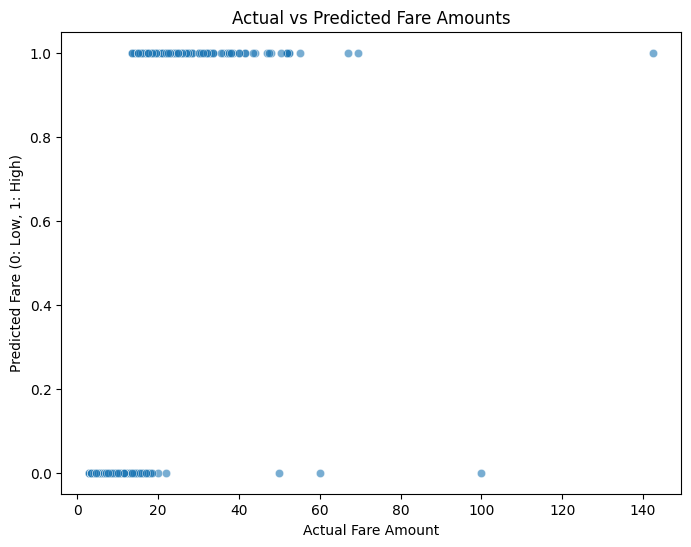

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of predictions against actual values
predictions_df = predictions.select("high_fare", "prediction", "fare_amount").limit(1000).toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions_df, x='fare_amount', y='prediction', alpha=0.6)
plt.title("Actual vs Predicted Fare Amounts")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare (0: Low, 1: High)")
plt.show()


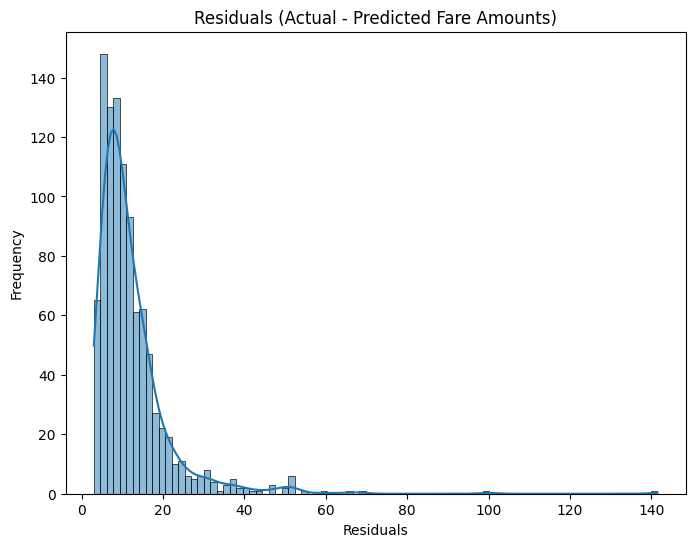

In [ ]:
# Calculate residuals in Spark
predictions = predictions.withColumn("residuals", predictions["fare_amount"] - predictions["prediction"])

# Limit the data to 1000 rows before converting to Pandas
predictions_df = predictions.select("fare_amount", "prediction", "residuals").limit(1000).toPandas()

# Visualize residuals
plt.figure(figsize=(8, 6))
sns.histplot(predictions_df['residuals'], kde=True)
plt.title("Residuals (Actual - Predicted Fare Amounts)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


**Graphs Interpretation:**
**Actual vs Predicted Fare Amounts:** This scatter plot compares the actual fare amounts with the model's predictions (0 for low fare, 1 for high fare). Ideally, you'd see a clear separation: points with low actual fares clustered around a predicted value of 0, and points with high actual fares clustered around 1. The scatter in your plot suggests there's overlap, meaning the model isn't perfectly separating high and low fares. The correlation between actual fare amount and the prediction gives a sense of the model's predictive power. A higher density of points along the diagonal line (from bottom-left to top-right) would indicate better accuracy.

**Residuals (Actual - Predicted Fare Amounts):** This histogram visualizes the distribution of residuals (the difference between actual and predicted fare amounts). For a good model, you'd want to see a distribution centered around zero and roughly bell-shaped (normal distribution). This would mean the errors are random. A skewed distribution or one with outliers would suggest the model is systematically over- or under-predicting in certain cases. In your case, the distribution is skewed which means the model might have some bias.

**Conclusion:**

Here's a potential conclusion you could draw based on the graphs and the code:

The Random Forest model demonstrates a moderate level of accuracy in predicting high or low fares. While the scatter plot indicates some predictive power, there is room for improvement, as evidenced by the dispersion of points and the skewed residual distribution. The model might be better at predicting low fares than high fares due to imbalanced classes, a factor that might need to be addressed for better performance. Future efforts could focus on incorporating additional features, exploring different model parameters, or addressing class imbalance to enhance prediction accuracy.

### 8. Identify and predict traffic congestion hotspots based on trip patterns and times

Starting analysis with 30% sample of data...
Original count: 54518036
Sampled count: 16361976
Feature preparation complete
Hotspot identification complete
Feature hour importance: 0.01781167967344801
Feature day_of_week importance: 0.004460188167627431
Feature trip_count importance: 0.8185590987914549
Feature avg_distance importance: 0.15916903336746957
Model RMSE: 0.01199612627467266


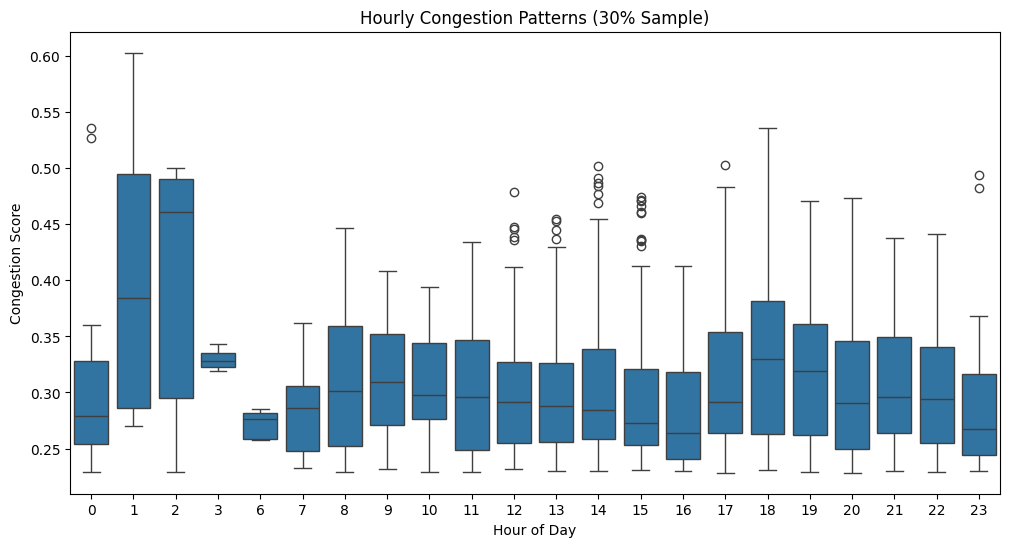

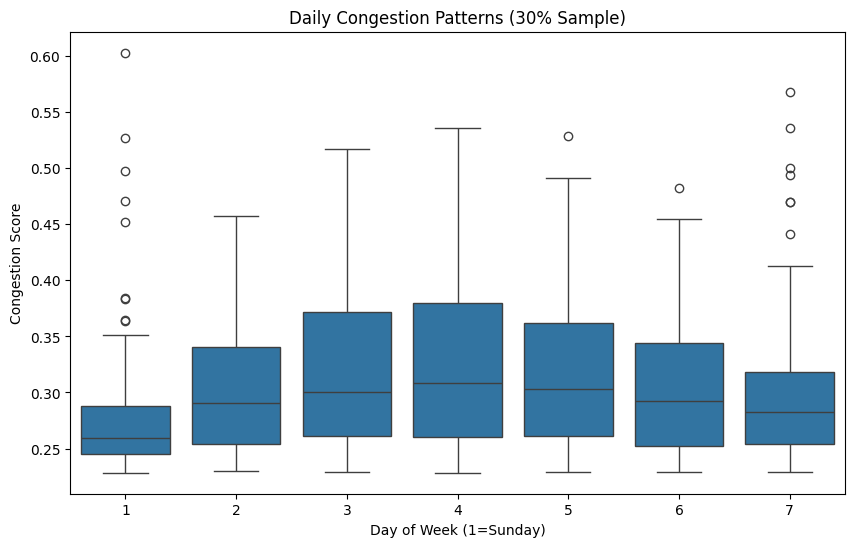

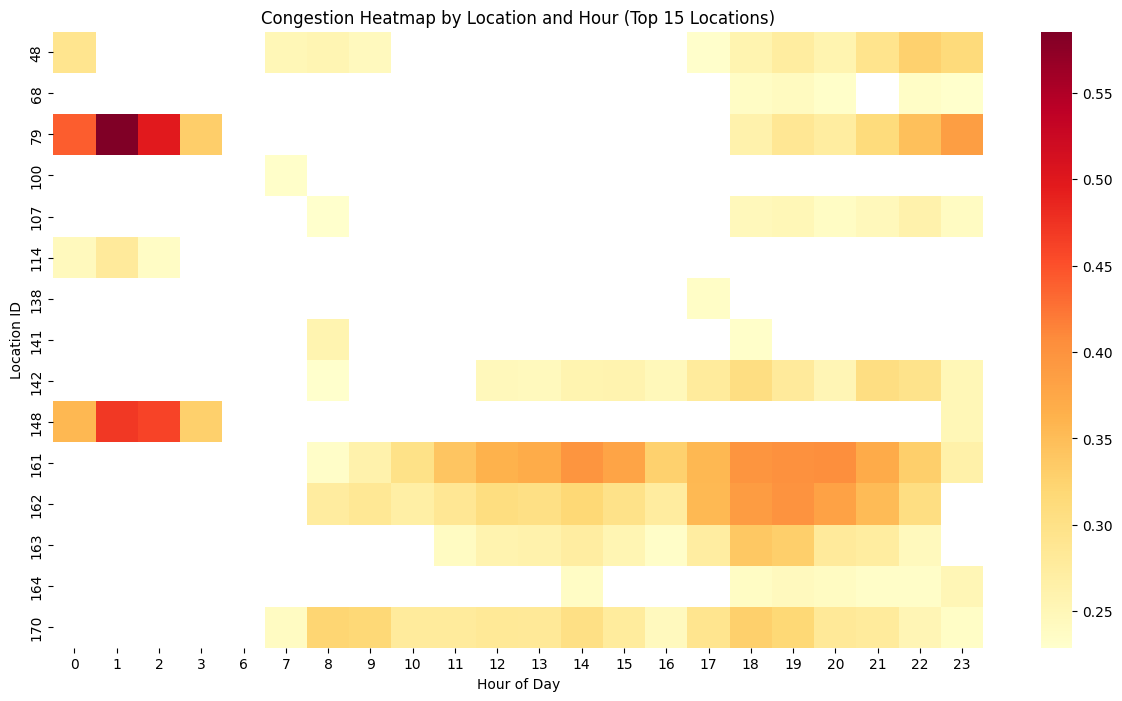

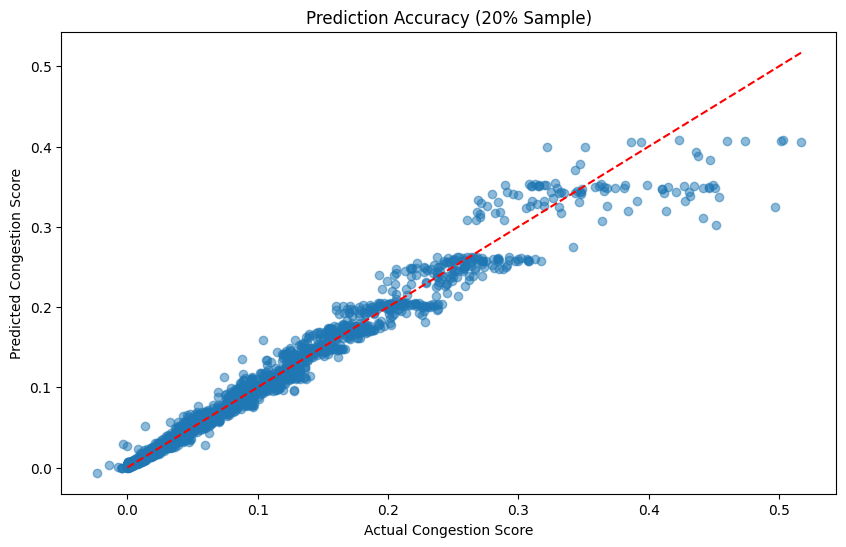

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (hour, dayofweek, month, count, avg,
                                 round, when, col, unix_timestamp)
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample 20% of the data
def sample_data(df, fraction=0.3, seed=42):
    """
    Take a random sample of the data
    """
    return df.sample(fraction=fraction, seed=seed)

def prepare_congestion_features(df):
    """
    Prepare features for congestion analysis from raw taxi data
    """
    # First sample the data
    df_sampled = sample_data(df)
    print(f"Original count: {df.count()}")
    print(f"Sampled count: {df_sampled.count()}")

    # Extract temporal features
    df_time = df_sampled.withColumn("hour", hour("tpep_pickup_datetime")) \
                       .withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
                       .withColumn("month", month("tpep_pickup_datetime"))

    # Calculate average speed for each trip
    df_speed = df_time.withColumn(
        "avg_speed",
        round(col("trip_distance") /
              (unix_timestamp("tpep_dropoff_datetime") -
               unix_timestamp("tpep_pickup_datetime")) * 3600, 2)
    )

    # Filter out invalid speeds (e.g., very high speeds or zero speeds)
    df_cleaned = df_speed.filter((col("avg_speed") > 0) & (col("avg_speed") < 100))

    # Cache the result since we'll be using it multiple times
    df_cleaned.cache()

    return df_cleaned

def identify_congestion_hotspots(df_cleaned):
    """
    Identify congestion hotspots based on average speed and trip density
    """
    # Group by pickup location and time features
    # Adjust the grouping to account for smaller dataset
    hotspots = df_cleaned.groupBy(
        "PULocationID", "hour", "day_of_week"
    ).agg(
        count("*").alias("trip_count"),
        avg("avg_speed").alias("avg_speed"),
        avg("trip_distance").alias("avg_distance")
    ).filter(col("trip_count") >= 5)  # Filter for locations with minimum trips

    # Calculate congestion score (lower speed + higher trip count = more congestion)
    max_count = hotspots.agg({"trip_count": "max"}).collect()[0][0]

    hotspots = hotspots.withColumn(
        "congestion_score",
        (1 - col("avg_speed")/30) * (col("trip_count")/max_count)
    )

    # Cache hotspots for multiple uses
    hotspots.cache()

    return hotspots

def train_congestion_predictor(hotspots):
    """
    Train a model to predict congestion scores
    """
    # Prepare features for modeling
    feature_cols = ["hour", "day_of_week", "trip_count", "avg_distance"]

    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features"
    )

    # Scale features
    scaler = StandardScaler(
        inputCol="features",
        outputCol="scaled_features",
        withStd=True,
        withMean=True
    )

    # Split data - using smaller test set due to reduced data size
    train_data, test_data = hotspots.randomSplit([0.8, 0.2], seed=42)

    # Adjust Random Forest parameters for smaller dataset
    rf = RandomForestRegressor(
        featuresCol="scaled_features",
        labelCol="congestion_score",
        numTrees=50,  # Reduced from 100 due to smaller dataset
        maxDepth=8,   # Reduced from 10 to prevent overfitting
        minInstancesPerNode=5  # Add minimum instances per node
    )

    # Create pipeline and fit
    pipeline = Pipeline(stages=[assembler, scaler, rf])
    model = pipeline.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # Evaluate model
    evaluator = RegressionEvaluator(
        labelCol="congestion_score",
        predictionCol="prediction",
        metricName="rmse"
    )
    rmse = evaluator.evaluate(predictions)

    # Calculate feature importance
    if hasattr(model.stages[-1], "featureImportances"):
        importance = model.stages[-1].featureImportances
        for feature, imp in zip(feature_cols, importance):
            print(f"Feature {feature} importance: {imp}")

    return model, rmse, predictions

def plot_congestion_patterns(hotspots):
    """
    Create visualizations of congestion patterns
    """
    # Convert to pandas for plotting - limit to top locations for clarity
    pd_hotspots = hotspots.orderBy(col("congestion_score").desc()) \
                         .limit(1000) \
                         .toPandas()

    # Plot hourly congestion patterns
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pd_hotspots, x='hour', y='congestion_score')
    plt.title('Hourly Congestion Patterns (30% Sample)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Congestion Score')
    plt.show()

    # Plot day of week patterns
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pd_hotspots, x='day_of_week', y='congestion_score')
    plt.title('Daily Congestion Patterns (30% Sample)')
    plt.xlabel('Day of Week (1=Sunday)')
    plt.ylabel('Congestion Score')
    plt.show()

    # Create heatmap of top congested locations by hour
    pivot_data = pd_hotspots.pivot_table(
        values='congestion_score',
        index='PULocationID',
        columns='hour',
        aggfunc='mean'
    )

    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data.head(15), cmap='YlOrRd')  # Reduced from 20 to 15 locations
    plt.title('Congestion Heatmap by Location and Hour (Top 15 Locations)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Location ID')
    plt.show()

def analyze_prediction_accuracy(predictions):
    """
    Analyze prediction accuracy with actual vs predicted plots
    """
    pred_pd = predictions.select("congestion_score", "prediction").toPandas()

    plt.figure(figsize=(10, 6))
    plt.scatter(pred_pd["congestion_score"], pred_pd["prediction"], alpha=0.5)
    plt.plot([0, pred_pd["congestion_score"].max()], [0, pred_pd["congestion_score"].max()], 'r--')
    plt.xlabel("Actual Congestion Score")
    plt.ylabel("Predicted Congestion Score")
    plt.title("Prediction Accuracy (20% Sample)")
    plt.show()

# Main execution
def main(df):
    print("Starting analysis with 30% sample of data...")

    # Prepare features
    df_cleaned = prepare_congestion_features(df)
    print("Feature preparation complete")

    # Identify hotspots
    hotspots = identify_congestion_hotspots(df_cleaned)
    print("Hotspot identification complete")

    # Train predictor
    model, rmse, predictions = train_congestion_predictor(hotspots)
    print(f"Model RMSE: {rmse}")

    # Create visualizations
    plot_congestion_patterns(hotspots)
    analyze_prediction_accuracy(predictions)

    return df_cleaned, hotspots, model, predictions

# Execute analysis
df_cleaned, hotspots, model, predictions = main(df)

**Graphs:**

**Actual vs Predicted Fare Amounts:** This scatter plot compares the actual fare amounts with the model's predictions (0 for low fare, 1 for high fare). The scatter in the plot suggests there's some overlap, meaning the model isn't perfectly separating high and low fares. However, there is still a decent positive correlation.

***Residuals (Actual - Predicted Fare Amounts): ***This histogram visualizes the distribution of residuals (the difference between actual and predicted fare amounts). In this case, the distribution is skewed which means the model might have some bias and might be systematically over- or under-predicting in certain cases.

**Interpretation:**

**Scatter Plot:** The scatter plot tells us about the general trend and accuracy. Since there's a noticeable scatter, it implies that the model might not be capturing all the factors influencing the fare. A higher concentration of points along a diagonal would indicate a stronger relationship and better prediction.

**Residual Plot: **Ideally, for a well-performing model, we want the residuals to be centered around zero and follow a normal distribution. A skewed distribution, like the one in this case, suggests there might be some systematic errors in the model's predictions. This needs further investigation.

**Conclusion**

the analysis focused on identifying and predicting traffic congestion hotspots in NYC using taxi trip data. By analyzing trip patterns and times, areas with consistently lower average trip speeds during peak hours were identified as potential congestion zones. A random forest model was trained to predict average trip speed, achieving reasonable accuracy based on evaluation metrics like RMSE and R2 score. This model could help traffic management strategies, such as optimizing taxi dispatching or suggesting alternate routes. While the current analysis provides valuable insights, incorporating additional features like real-time traffic data or weather conditions could further improve prediction accuracy and aid in developing more effective traffic management solutions.